## Confronting Confounding

### Elemental Confounds

* Fork: $X \leftarrow Z \rightarrow Y$
* Pipe: $X \rightarrow Z \rightarrow Y$
* Collider: $X \rightarrow Z \leftarrow Y$
* Descendant: 

In [1]:
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel


fork = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("Z", "X"), 
        ("Z", "Y")
    ]
)

pipe = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"), 
        ("Z", "Y")
    ]
)


collider = CausalGraphicalModel(
    nodes=["X", "Y", "Z"],
    edges=[
        ("X", "Z"), 
        ("Y", "Z")
    ]
)

desc = CausalGraphicalModel(
    nodes=["X", "Y", "Z", "D"],
    edges=[
        ("X", "Z"), 
        ("Y", "Z"), 
        ("Z", "D")
    ]
)

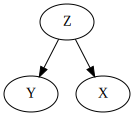

In [2]:
fork.draw()

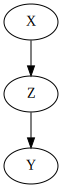

In [3]:
pipe.draw()

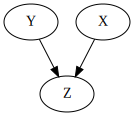

In [4]:
collider.draw()

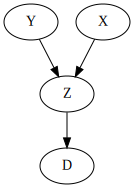

In [5]:
desc.draw()

## Example 6.4.2

The following code was lifted from https://github.com/pymc-devs/resources/blob/master/Rethinking_2/Chp_06.ipynb who, in turn, credit https://ksachdeva.github.io/rethinking-tensorflow-probability/

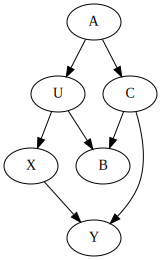

In [6]:
dag_6_1 = CausalGraphicalModel(
    nodes=["X", "Y", "C", "U", "B", "A"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("A", "U"),
        ("A", "C"),
        ("C", "Y"),
        ("U", "B"),
        ("C", "B"),
    ],
)

dag_6_1.draw() 

In [7]:
dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'A', 'U'}),
           frozenset({'C'}),
           frozenset({'A'}),
           frozenset({'C', 'U'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'B', 'C'}),
           frozenset({'U'}),
           frozenset({'B', 'U'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'A', 'B', 'C', 'U'})})

In [8]:
all_adjustment_sets = dag_6_1.get_all_backdoor_adjustment_sets("X", "Y")

for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        if s != {"U"}:
            print(s)

frozenset({'C'})
frozenset({'A'})


## Example 6.4.3

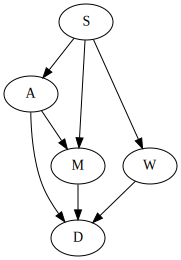

In [9]:
dag_6_2 = CausalGraphicalModel(
    nodes=["S", "A", "M", "D", "W"],
    edges=[
        ("S", "W"),
        ("S", "M"),
        ("S", "A"),
        ("A", "M"),
        ("A", "D"),
        ("M", "D"),
        ("W", "D"),
    ],
)

dag_6_2.draw() 

In [10]:
all_adjustment_sets = dag_6_2.get_all_backdoor_adjustment_sets("W", "D")

for s in all_adjustment_sets:
    if all(not t.issubset(s) for t in all_adjustment_sets if t != s):
        print(s)

frozenset({'M', 'A'})
frozenset({'S'})


In [11]:
all_independencies = dag_6_2.get_all_independence_relationships()

all_independencies

[('S', 'D', {'A', 'M', 'W'}),
 ('A', 'W', {'S'}),
 ('A', 'W', {'M', 'S'}),
 ('M', 'W', {'S'}),
 ('M', 'W', {'A', 'S'})]

## Experiment 1

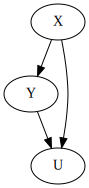

In [12]:
dag_6_3 = CausalGraphicalModel(
    nodes=["X", "Y", "U"],
    edges=[
        ("X", "Y"),
        ("X", "U"),
        ("Y", "U"),
    ],
)

dag_6_3.draw() 

## Discussion

In this case, conditioning on $U$ opens the non-causal path $X \rightarrow U \leftarrow Y$ and leads to a different estimate of $b_{xy}$. The correct approach would be to exclude $U$ in the regression.

In [13]:
import arviz as az
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm


N = 1000
b_xy = 1
b_xu = 2
b_yu = 3

x = norm.rvs(loc=0, scale=1, size=N)
y = b_xy * x + norm.rvs(loc=0, scale=2, size=N)
u = b_xu * x  + b_yu * y + norm.rvs(loc=0, scale=3, size=N)

df = pd.DataFrame({'x':x, 'y': y, 'u': u})
df.head()

,x,y,u
0,0.715079,2.360915,8.350655
1,1.155553,3.441224,9.446367
2,0.537140,-0.331467,-2.673217
3,-0.098589,-0.847952,-1.348322
4,-0.742137,-1.792434,-10.176709


In [14]:
with pm.Model() as m_exp1_1:
    a  = pm.Normal('a', mu=0, sigma=0.01)
    b_xy = pm.Normal('b_xy', mu=1, sigma=2)
    b_uy = pm.Normal('b_uy', mu=0, sigma=2)
    
    mu = a + b_xy * df['x'].values + b_uy * df['u'].values
    sigma = pm.Exponential('sigma', lam=1)
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'].values)
    
    trace_exp1_1 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_exp1_1, var_names=['b_xy', 'b_uy', 'a', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 27300
Interrupted at 27,299 [13%]: Average Loss = 7,026.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_uy, b_xy, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_xy,-0.298,0.036,-0.356,-0.242,0.0,0.0,5778.0,5778.0,5788.0,5627.0,1.0
b_uy,0.259,0.004,0.252,0.266,0.0,0.0,6081.0,6081.0,6100.0,5668.0,1.0
a,-0.000,0.010,-0.016,0.015,0.0,0.0,7340.0,4352.0,7358.0,5867.0,1.0
sigma,0.886,0.020,0.854,0.917,0.0,0.0,8198.0,8198.0,8182.0,5695.0,1.0


In [15]:
with pm.Model() as m_exp1_2:
    a  = pm.Normal('a', mu=0, sigma=0.01)
    b_xy = pm.Normal('b_xy', mu=1, sigma=2)
    
    mu = a + b_xy * df['x'].values
    sigma = pm.Exponential('sigma', lam=1)
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df['y'].values)
    
    trace_exp1_2 = pm.sample(2000, init='advi', tune=2000)

az.summary(trace_exp1_2, var_names=['b_xy', 'a', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 21700
Interrupted at 21,699 [10%]: Average Loss = 3,102.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_xy, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_xy,1.072,0.061,0.972,1.167,0.001,0.0,9476.0,9460.0,9479.0,5382.0,1.0
a,0.001,0.010,-0.015,0.016,0.000,0.0,9869.0,4036.0,9888.0,6100.0,1.0
sigma,1.933,0.045,1.865,2.009,0.000,0.0,10755.0,10702.0,10876.0,5740.0,1.0


## Experiment 2

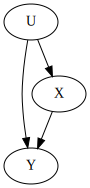

In [16]:
dag_6_4 = CausalGraphicalModel(
    nodes=["X", "Y", "U"],
    edges=[
        ("X", "Y"),
        ("U", "X"),
        ("U", "Y"),
    ],
)

dag_6_4.draw() 

## Discussion

In this case, _not_ taking $U$ in the regression leaves the backdoor $X \leftarrow U \rightarrow Y$ open. The correct approach would be to include $U$ in the regression.

In [17]:
N = 1000
b_xy = 1
b_ux = 2
b_uy = 3

u = norm.rvs(loc=0, scale=1, size=N)
x = b_ux * u + norm.rvs(loc=0, scale=2, size=N)
y = b_xy * x + b_uy * u + norm.rvs(loc=0, scale=3, size=N)

df_2 = pd.DataFrame({'x':x, 'y': y, 'u': u})
df_2.head()

,x,y,u
0,2.278518,-2.499995,0.537822
1,-1.204864,3.741434,0.800866
2,-3.755139,-6.603420,-0.888493
3,5.552362,16.346002,2.278009
4,0.008462,10.909319,0.408222


In [18]:
with pm.Model() as m_exp2_1:
    a  = pm.Normal('a', mu=0, sigma=0.01)
    b_xy = pm.Normal('b_xy', mu=1, sigma=2)
    b_uy = pm.Normal('b_uy', mu=3, sigma=2)
    
    mu = a + b_xy * df_2['x'].values + b_uy * df_2['u'].values
    sigma = pm.Exponential('sigma', lam=1)
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df_2['y'].values)
    
    trace_exp2_1 = pm.sample(2000, init='advi', tune=4000)

az.summary(trace_exp2_1, var_names=['b_xy', 'b_uy', 'a', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 19800
Interrupted at 19,799 [9%]: Average Loss = 5,621.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_uy, b_xy, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 10 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_xy,1.032,0.05,0.952,1.112,0.001,0.001,2815.0,2806.0,2817.0,3965.0,1.0
b_uy,2.973,0.14,2.733,3.182,0.003,0.002,2745.0,2745.0,2747.0,4335.0,1.0
a,0.002,0.01,-0.015,0.018,0.000,0.000,12864.0,3936.0,12882.0,5156.0,1.0
sigma,3.050,0.07,2.931,3.155,0.001,0.000,12850.0,12795.0,13072.0,6207.0,1.0


In [19]:
with pm.Model() as m_exp2_2:
    a  = pm.Normal('a', mu=0, sigma=0.01)
    b_xy = pm.Normal('b_xy', mu=1, sigma=2)

    mu = a + b_xy * df_2['x'].values
    sigma = pm.Exponential('sigma', lam=1)
    
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df_2['y'].values)
    
    trace_exp2_2 = pm.sample(2000, init='advi', tune=4000)

az.summary(trace_exp2_2, var_names=['b_xy', 'a', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Convergence achieved at 17600
Interrupted at 17,599 [8%]: Average Loss = 7,861.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_xy, a]


Sampling 4 chains for 4_000 tune and 2_000 draw iterations (16_000 + 8_000 draws total) took 12 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b_xy,1.776,0.043,1.708,1.845,0.001,0.000,4323.0,4323.0,4327.0,4671.0,1.0
a,0.001,0.010,-0.015,0.017,0.000,0.000,8671.0,3630.0,8658.0,5671.0,1.0
sigma,3.687,0.083,3.558,3.819,0.001,0.001,9332.0,9280.0,9389.0,5291.0,1.0
